In [249]:
#Import the necessary libraries
import numpy as np
import pandas as pd
import json
import re
import datetime
from datetime import datetime as dt
from matplotlib import pyplot as plt
import sqlite3
from pandasql import sqldf

In [250]:
pd.set_option('display.max_rows', 11)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [251]:
#Read the users data frame. Do not convert dates as they are in POSIX format
users_df = pd.read_json('users.json', lines=True, convert_dates=False)
users_df.head()

,contributors_enabled,created_at,default_profile,default_profile_image,description,entities,favourites_count,follow_request_sent,followers_count,following,friends_count,geo_enabled,has_extended_profile,id,id_str,is_translation_enabled,is_translator,lang,listed_count,location,name,notifications,profile_background_color,profile_background_image_url,profile_background_image_url_https,profile_background_tile,profile_banner_url,profile_image_url,profile_image_url_https,profile_link_color,profile_sidebar_border_color,profile_sidebar_fill_color,profile_text_color,profile_use_background_image,protected,screen_name,statuses_count,time_zone,translator_type,url,utc_offset,verified
0,False,1417384037,True,False,"Official Twitter page of Alaska Governor Bill Walker; honored to serve AK w/ @LtGovMallott. RTs ≠ endorsements.Tweets signed ""-BW"" come directly from Governor.","{'description': {'urls': []}, 'url': {'urls': [{'display_url': 'gov.alaska.gov', 'expanded_url': 'http://gov.alaska.gov', 'indices': [0, 22], 'url': 'http://t.co/NO67LyZvUR'}]}}",115,False,5870,False,550,True,False,2915095729,2915095729,False,False,en,190,Alaska,Governor Bill Walker,False,C0DEED,http://abs.twimg.com/images/themes/theme1/bg.png,https://abs.twimg.com/images/themes/theme1/bg.png,False,https://pbs.twimg.com/profile_banners/2915095729/1417385137,http://pbs.twimg.com/profile_images/737753674466787329/rmi2xV_E_normal.jpg,https://pbs.twimg.com/profile_images/737753674466787329/rmi2xV_E_normal.jpg,1DA1F2,C0DEED,DDEEF6,333333,True,False,AkGovBillWalker,1642,None,none,http://t.co/NO67LyZvUR,NaN,True
1,False,1240239576,False,False,"U.S. Senator from Minnesota. Follows, Retweets, Replies ≠ endorsement","{'description': {'urls': []}, 'url': {'urls': [{'display_url': 'amyklobuchar.com', 'expanded_url': 'http://www.amyklobuchar.com', 'indices': [0, 22], 'url': 'http://t.co/mGGFBfggto'}]}}",24,False,170717,False,91751,False,False,33537967,33537967,False,False,en,2493,,Amy Klobuchar,False,026113,http://abs.twimg.com/images/themes/theme1/bg.png,https://abs.twimg.com/images/themes/theme1/bg.png,False,NaN,http://pbs.twimg.com/profile_images/1815362035/AJK_Twitter_normal.jpg,https://pbs.twimg.com/profile_images/1815362035/AJK_Twitter_normal.jpg,026113,F6D73F,89BCEE,3D3C3D,True,False,amyklobuchar,5567,Central Time (US & Canada),none,http://t.co/mGGFBfggto,-18000.0,True
2,False,1366837593,False,False,"Congressman for Maryland's 4th Congressional District, former Army Aviator, father and husband","{'description': {'urls': []}, 'url': {'urls': [{'display_url': 'anthonybrown.com', 'expanded_url': 'http://www.anthonybrown.com', 'indices': [0, 23], 'url': 'https://t.co/NYPWOVmoAx'}]}}",90,False,6067,False,369,True,True,1378000346,1378000346,False,False,en,170,"Mitchellville, MD",Anthony G. Brown,False,184466,http://pbs.twimg.com/profile_background_images/884068111/76c403a1354bd42620a38d317f6d0a23.jpeg,https://pbs.twimg.com/profile_background_images/884068111/76c403a1354bd42620a38d317f6d0a23.jpeg,True,https://pbs.twimg.com/profile_banners/1378000346/1479909083,http://pbs.twimg.com/profile_images/801128012573970433/2MGZIRal_normal.jpg,https://pbs.twimg.com/profile_images/801128012573970433/2MGZIRal_normal.jpg,6B2E13,FFFFFF,DDEEF6,333333,False,False,AnthonyBrownMD4,1878,Eastern Time (US & Canada),none,https://t.co/NYPWOVmoAx,-14400.0,True
3,False,1300739574,False,False,"Husband of 43 yrs, Dad of 4, Papaw of 6. Lifelong Arkansan. Governor of Arkansas. Former Congressman, Admin. of DEA, Under Sec. of Homeland Security.","{'description': {'urls': []}, 'url': {'urls': [{'display_url': 'governor.arkansas.gov', 'expanded_url': 'http://www.governor.arkansas.gov', 'indices': [0, 23], 'url': 'https://t.co/b38CUNlZHi'}]}}",440,False,25747,False,598,True,True,269992801,269992801,False,False,en,420,Arkansas,Gov. Asa Hutchinson,False,C0DEED,http://pbs.twimg.com/profile_background_images/378800000022012499/f440cc71434509f7036d04f5ed7cd67e.jpeg,https://pbs.twimg.com/profile_background_images/3788000

In [252]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 42 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   contributors_enabled                548 non-null    bool   
 1   created_at                          548 non-null    object 
 2   default_profile                     548 non-null    bool   
 3   default_profile_image               548 non-null    bool   
 4   description                         548 non-null    object 
 5   entities                            545 non-null    object 
 6   favourites_count                    548 non-null    int64  
 7   follow_request_sent                 548 non-null    bool   
 8   followers_count                     548 non-null    int64  
 9   following                           548 non-null    bool   
 10  friends_count                       548 non-null    int64  
 11  geo_enabled                         548 non-n

In [253]:
#Our created_at column contains different formats, both Unix timestamps as well as other formats. 
#Convert everything into a Unix format
#Then convert it to Int
#Then apply UTC conversion to get proper timestamp

def convert_to_unix_int(timestamp_str):
    try:
        # Attempt to convert as an integer (Unix timestamp)
        return int(timestamp_str)
    except ValueError:
        try:
            # Attempt to parse the different format
            timestamp = dt.strptime(timestamp_str, '%a %b %d %H:%M:%S %z %Y')
            return int(timestamp.timestamp())
        except ValueError:
            # Handle any other cases or return None for unsupported formats
            return None

# Apply the conversion function to the 'created_at' column
users_df['created_at'] = users_df['created_at'].apply(convert_to_unix_int)

# Now, the 'created_at' column contains Unix timestamps where possible
#Apply lambda function to convert to UTC Timestamp
users_df['created_at'] = users_df['created_at'].apply(lambda x: dt.utcfromtimestamp(x))

In [254]:
users_df.head()

,contributors_enabled,created_at,default_profile,default_profile_image,description,entities,favourites_count,follow_request_sent,followers_count,following,friends_count,geo_enabled,has_extended_profile,id,id_str,is_translation_enabled,is_translator,lang,listed_count,location,name,notifications,profile_background_color,profile_background_image_url,profile_background_image_url_https,profile_background_tile,profile_banner_url,profile_image_url,profile_image_url_https,profile_link_color,profile_sidebar_border_color,profile_sidebar_fill_color,profile_text_color,profile_use_background_image,protected,screen_name,statuses_count,time_zone,translator_type,url,utc_offset,verified
0,False,2014-11-30 21:47:17,True,False,"Official Twitter page of Alaska Governor Bill Walker; honored to serve AK w/ @LtGovMallott. RTs ≠ endorsements.Tweets signed ""-BW"" come directly from Governor.","{'description': {'urls': []}, 'url': {'urls': [{'display_url': 'gov.alaska.gov', 'expanded_url': 'http://gov.alaska.gov', 'indices': [0, 22], 'url': 'http://t.co/NO67LyZvUR'}]}}",115,False,5870,False,550,True,False,2915095729,2915095729,False,False,en,190,Alaska,Governor Bill Walker,False,C0DEED,http://abs.twimg.com/images/themes/theme1/bg.png,https://abs.twimg.com/images/themes/theme1/bg.png,False,https://pbs.twimg.com/profile_banners/2915095729/1417385137,http://pbs.twimg.com/profile_images/737753674466787329/rmi2xV_E_normal.jpg,https://pbs.twimg.com/profile_images/737753674466787329/rmi2xV_E_normal.jpg,1DA1F2,C0DEED,DDEEF6,333333,True,False,AkGovBillWalker,1642,None,none,http://t.co/NO67LyZvUR,NaN,True
1,False,2009-04-20 14:59:36,False,False,"U.S. Senator from Minnesota. Follows, Retweets, Replies ≠ endorsement","{'description': {'urls': []}, 'url': {'urls': [{'display_url': 'amyklobuchar.com', 'expanded_url': 'http://www.amyklobuchar.com', 'indices': [0, 22], 'url': 'http://t.co/mGGFBfggto'}]}}",24,False,170717,False,91751,False,False,33537967,33537967,False,False,en,2493,,Amy Klobuchar,False,026113,http://abs.twimg.com/images/themes/theme1/bg.png,https://abs.twimg.com/images/themes/theme1/bg.png,False,NaN,http://pbs.twimg.com/profile_images/1815362035/AJK_Twitter_normal.jpg,https://pbs.twimg.com/profile_images/1815362035/AJK_Twitter_normal.jpg,026113,F6D73F,89BCEE,3D3C3D,True,False,amyklobuchar,5567,Central Time (US & Canada),none,http://t.co/mGGFBfggto,-18000.0,True
2,False,2013-04-24 21:06:33,False,False,"Congressman for Maryland's 4th Congressional District, former Army Aviator, father and husband","{'description': {'urls': []}, 'url': {'urls': [{'display_url': 'anthonybrown.com', 'expanded_url': 'http://www.anthonybrown.com', 'indices': [0, 23], 'url': 'https://t.co/NYPWOVmoAx'}]}}",90,False,6067,False,369,True,True,1378000346,1378000346,False,False,en,170,"Mitchellville, MD",Anthony G. Brown,False,184466,http://pbs.twimg.com/profile_background_images/884068111/76c403a1354bd42620a38d317f6d0a23.jpeg,https://pbs.twimg.com/profile_background_images/884068111/76c403a1354bd42620a38d317f6d0a23.jpeg,True,https://pbs.twimg.com/profile_banners/1378000346/1479909083,http://pbs.twimg.com/profile_images/801128012573970433/2MGZIRal_normal.jpg,https://pbs.twimg.com/profile_images/801128012573970433/2MGZIRal_normal.jpg,6B2E13,FFFFFF,DDEEF6,333333,False,False,AnthonyBrownMD4,1878,Eastern Time (US & Canada),none,https://t.co/NYPWOVmoAx,-14400.0,True
3,False,2011-03-21 20:32:54,False,False,"Husband of 43 yrs, Dad of 4, Papaw of 6. Lifelong Arkansan. Governor of Arkansas. Former Congressman, Admin. of DEA, Under Sec. of Homeland Security.","{'description': {'urls': []}, 'url': {'urls': [{'display_url': 'governor.arkansas.gov', 'expanded_url': 'http://www.governor.arkansas.gov', 'indices': [0, 23], 'url': 'https://t.co/b38CUNlZHi'}]}}",440,False,25747,False,598,True,True,269992801,269992801,False,False,en,420,Arkansas,Gov. Asa Hutchinson,False,C0DEED,http://pbs.twimg.com/profile_background_images/378800000022012499/f440cc71434509f7036d04f5ed7cd67e.jpeg,https://pbs.twimg.c

In [255]:
pd.set_option('display.max_rows', None)  # Set the maximum rows to display
users_df['location'].value_counts()
#TODO: Clean the Location Column so similar cities like Washington, DC and Washington, D.C. are counted as the same cities.

                                  134
Washington, DC                     24
Washington, D.C.                    7
Oklahoma                            4
Oregon                              4
New York, NY                        3
Colorado                            3
Houston, TX                         3
Las Vegas, NV                       2
Chicago, IL                         2
Delaware                            2
Washington, D.C.                    2
Arizona, USA                        2
California                          2
Iowa                                2
Carson City, NV                     2
Arizona                             2
New York                            2
Louisiana, USA                      2
Utah                                2
Hartford, CT                        2
Tennessee                           2
United States                       2
Missouri                            2
Massachusetts                       2
Stockton, CA                        1
Saratoga Spr

In [256]:
#Let us scrape State information from Wikipedia
#We are going to store 5 columns - State, State Abbreviation, Population, Population Percentage, Abbreviation
#Import beautiful soup for scraping
import requests
from bs4 import BeautifulSoup

# The URL of the Wikipedia page
url = "https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States"

# Send an HTTP GET request to the URL
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Parse the HTML content of the page
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find the table containing the list of states and territories
    table = soup.find('table', {'class': 'wikitable'})

    if table:
        # Initialize lists to store the state names and cities
        state_names = []
        state_abbr = []
        state_cap = []
        state_pop = []
        

        # Find all rows in the table (skip the header row)
        rows = table.find_all('tr')[2:]

        for row in rows:
            # Extract the state name (from the first column)
            state_name = row.find('th').text.strip()
            if '[B]' in state_name:
                cleaned_name = state_name.replace('[B]', '')
            else:
                cleaned_name = state_name
                
            
            #Extract the abbreviation of the state
            abbr = row.find('td').text.strip()

            # Extract the list of cities (from the second column, if available)
            city_column = row.find_all('td')
            city_names = city_column[1].text.strip()

                
            # Extract population from fourth column (from the second column, if available)
            pop_column = row.find_all('td')
            pop_num = pop_column[-8].text.strip()


            # Append state name and cities to the respective lists
            state_abbr.append(abbr)
            state_names.append(cleaned_name)
            state_cap.append(city_names)
            population_int = int(pop_num.replace(",", ""))
            state_pop.append(population_int)

    else:
        print("Table not found on the page.")

else:
    print(f"Failed to retrieve the page. Status code: {response.status_code}")
    

state_df = pd.DataFrame ({
    'State':state_names,
    'Abbreviation':state_abbr,
    'Capital':state_cap,
    'Population':state_pop
})
total_population = state_df['Population'].sum()
state_df['Percentage'] = (state_df['Population']/total_population)*100
state_df['Percentage'] = state_df['Percentage'].round(2)
state_df

,State,Abbreviation,Capital,Population,Percentage
0,Alabama,AL,Montgomery,5024279,1.52
1,Alaska,AK,Juneau,733391,0.22
2,Arizona,AZ,Phoenix,7151502,2.16
3,Arkansas,AR,Little Rock,3011524,0.91
4,California,CA,Sacramento,39538223,11.95
5,Colorado,CO,Denver,5773714,1.75
6,Connecticut,CT,Hartford,3605944,1.09
7,Delaware,DE,Dover,989948,0.30
8,Florida,FL,Tallahassee,21538187,6.51
9,Georgia,GA,Atlanta,10711908,3.24


In [257]:
#Now we're going to create a new column called States, which will check if each of the States matches 
#the description or location of each User. If it does, it will Place that state's name in the State column
#We will use this column over location for our analysis.
pd.reset_option('display.max_rows')
def find_state(row, states):
    for state in states['State']:
        if state in row['description'] or state in row['location']:
            return state
    for abbr in states['Abbreviation']:
        if abbr in row['description'] or abbr in row['location']:
            return states.loc[states['Abbreviation'] == abbr, 'State'].values[0]
    return None  # Return None if no state match is found

# Apply the find_state function to each row in the 'users' DataFrame and create a 'State' column
users_df['State'] = users_df.apply(find_state, args=(state_df,), axis=1)
users_df['State'].value_counts()

California        46
Washington        37
Texas             30
New York          26
Florida           25
Pennsylvania      19
Virginia          16
Michigan          16
Illinois          16
Ohio              16
North Carolina    15
Georgia           14
New Jersey        12
Maryland          11
Alabama           10
Arizona           10
Minnesota         10
South Carolina    10
Tennessee         10
Colorado          10
Missouri          10
Indiana            9
Louisiana          8
Iowa               8
Connecticut        8
Oregon             8
Massachusetts      8
Arkansas           7
Nevada             7
Oklahoma           7
Kansas             7
Hawaii             6
Utah               6
New Mexico         6
Kentucky           6
Wisconsin          5
Nebraska           5
New Hampshire      5
Maine              5
Mississippi        5
Alaska             4
South Dakota       4
Montana            4
Rhode Island       4
Delaware           4
Idaho              4
Vermont            3
Wyoming      

In [258]:
#This output seems satisfactory for our analysis. In real world situations, we have to be more discerning.
#Now let's look at the entities column and what it represents.
#short_url = "http://t.co/NO67LyZvUR"

# Send an HTTP GET request to the short URL
#response = requests.get(short_url)

# Check if the request was successful
#if response.status_code == 200:
    # Get the final (long) URL from the response
 #   long_url = response.url
#    print("Long URL:", long_url)
#else:
 #   print("Failed to expand the short URL. Status code:", response.status_code)

In [259]:
#The URL column in the users table contains short form twitter URLs for each user. 
#We can get individual URLs using HTTP Requests
#def expand_short_url(short_url):
#    try:
#        response = requests.get(short_url)
#        if response.status_code == 200:
 #           return response.url
#       else:
 #           return "Failed to expand"
#    except requests.exceptions.RequestException:
#        return "Failed to connect"
#users_df['website'] = users_df['url'].apply(expand_short_url)

In [260]:
#This query takes too long to run and as per the output we get failed to connect for some users
#To fix this, we are going to find another method.
#users_df['website']

In [261]:
users_df['entities'][0]
#Exploring the entities column, we see that this column contains the URL for each user
#Hence, we can use the entities column to extract the website for each user.

{'description': {'urls': []},
 'url': {'urls': [{'display_url': 'gov.alaska.gov',
    'expanded_url': 'http://gov.alaska.gov',
    'indices': [0, 22],
    'url': 'http://t.co/NO67LyZvUR'}]}}

In [262]:
#Function to extract the URL from the JSON dictionaries in the entities column in Users table
def extract_website (entities):
    if isinstance (entities, dict):
        try:
            if 'url' in entities and 'urls' in entities['url']:
                urls = entities['url']['urls']
                if urls:
                    website = urls[0]['expanded_url']
                    return website
                
        except KeyError:
            pass
    return None


users_df['website'] = users_df['entities'].apply(extract_website)

In [263]:
users_df['website']
#Now we have websites for each of the users in a separate column.

0                 http://gov.alaska.gov
1           http://www.amyklobuchar.com
2           http://www.anthonybrown.com
3      http://www.governor.arkansas.gov
4          http://austinscott.house.gov
                     ...               
543           http://www.foxx.house.gov
544         https://davidson.house.gov/
545           http://DemocraticWhip.gov
546          http://www.governor.wv.gov
547                                None
Name: website, Length: 548, dtype: object

In [264]:
null_count = users_df['website'].isnull().sum()
print(null_count)
#We have 37 columns as Null

37


In [265]:
#Storing only the columns we need.
users_df = users_df[['created_at','description','favourites_count','followers_count','friends_count','geo_enabled','id',
                    'listed_count','State','name','screen_name','statuses_count','time_zone','verified','website']]

In [266]:
users_df

,created_at,description,favourites_count,followers_count,friends_count,geo_enabled,id,listed_count,State,name,screen_name,statuses_count,time_zone,verified,website
0,2014-11-30 21:47:17,"Official Twitter page of Alaska Governor Bill Walker; honored to serve AK w/ @LtGovMallott. RTs ≠ endorsements.Tweets signed ""-BW"" come directly from Governor.",115,5870,550,True,2915095729,190,Alaska,Governor Bill Walker,AkGovBillWalker,1642,None,True,http://gov.alaska.gov
1,2009-04-20 14:59:36,"U.S. Senator from Minnesota. Follows, Retweets, Replies ≠ endorsement",24,170717,91751,False,33537967,2493,Minnesota,Amy Klobuchar,amyklobuchar,5567,Central Time (US & Canada),True,http://www.amyklobuchar.com
2,2013-04-24 21:06:33,"Congressman for Maryland's 4th Congressional District, former Army Aviator, father and husband",90,6067,369,True,1378000346,170,Maryland,Anthony G. Brown,AnthonyBrownMD4,1878,Eastern Time (US & Canada),True,http://www.anthonybrown.com
3,2011-03-21 20:32:54,"Husband of 43 yrs, Dad of 4, Papaw of 6. Lifelong Arkansan. Governor of Arkansas. Former Congressman, Admin. of DEA, Under Sec. of Homeland Security.",440,25747,598,True,269992801,420,Arkansas,Gov. Asa Hutchinson,AsaHutchinson,3778,Central Time (US & Canada),True,http://www.governor.arkansas.gov
4,2011-01-06 16:01:46,I am proud to represent the 8th Congressional District of Georgia.,12,13048,313,True,234797704,735,Georgia,Rep. Austin Scott,AustinScottGA08,2022,None,True,http://austinscott.house.gov
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,2008-09-12 13:30:07,Congresswoman Virginia Foxx. Conservative representing North Carolina's Fifth District.,35,18765,1334,True,16256269,1325,North Carolina,Virginia Foxx,virginiafoxx,3477,Eastern Time (US & Canada),True,http://www.foxx.house.gov
544,2016-06-14 15:08:44,U.S. Congressman serving Ohio's 8th District. Constitutionalist and former Army Ranger. Don't bankrupt America! Personal tweets signed -WD.,435,6323,4246,True,742735530287304704,236,Ohio,Warren Davidson,WarrenDavidson,679,Pacific Time (US & Canada),True,https://davidson.house.gov/
545,2009-02-26 14:13:01,"The Democratic Whip of the U.S. House of Representatives, representing Maryland's 5th Congressional District.",40,94320,4041,True,22012091,2593,Maryland,Steny Hoyer,WhipHoyer,12349,Eastern Time (US & Canada),True,http://DemocraticWhip.gov
546,2012-06-13 16:08:01,Jim Justice is the 36th Governor of the State of West Virginia. Account run by the Governor's Office. Tweets from Governor Justice signed -JJ.,42,22267,126,False,607332953,307,Virginia,Governor Jim Justice,WVGovernor,3873,Eastern Time (US & Canada),True,http://www.governor.wv.gov


In [267]:
correlation = users_df['followers_count'].corr(users_df['statuses_count'])

# Print the correlation coefficient
print("Pearson's correlation coefficient:", correlation)

Pearson's correlation coefficient: 0.33813864770764945


In [268]:
correlation = users_df['followers_count'].corr(users_df['listed_count'])

# Print the correlation coefficient
print("Pearson's correlation coefficient:", correlation)

Pearson's correlation coefficient: 0.8748125841980409


In [269]:
tweets_df = pd.read_json('tweets.json', lines=True)
tweets_df.head()

,contributors,coordinates,created_at,display_text_range,entities,favorite_count,favorited,geo,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,lang,place,retweet_count,retweeted,screen_name,source,text,truncated,user_id,possibly_sensitive,extended_entities,quoted_status_id,quoted_status_id_str,withheld_copyright,withheld_in_countries,withheld_scope
0,NaN,None,2008-08-04 17:28:51,"[0, 74]","{'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []}",0,False,None,877418565,877418565,None,NaN,NaN,NaN,NaN,False,en,None,0,False,JohnBoozman,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",On a conference call about a weekend trip to Iraq to visit Arkansas troops,False,5558312,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,None,2008-08-06 19:04:45,"[0, 25]","{'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []}",0,False,None,879618172,879618172,None,NaN,NaN,NaN,NaN,False,nl,None,0,False,JohnBoozman,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Being interviewed by KTHV,False,5558312,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,None,2008-08-06 20:35:36,"[0, 65]","{'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []}",0,False,None,879695803,879695803,None,NaN,NaN,NaN,NaN,False,en,None,0,False,JohnBoozman,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Being interviewed by KARN on his Arkansas World Trade Center trip,False,5558312,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,None,2008-08-07 13:52:52,"[0, 37]","{'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []}",0,False,None,880393665,880393665,None,NaN,NaN,NaN,NaN,False,en,None,0,False,JohnBoozman,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>","On KWHN in Fort Smith, that's 1320 AM",False,5558312,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,None,2008-08-07 15:12:05,"[0, 90]","{'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []}",0,False,None,880474266,880474266,None,NaN,NaN,NaN,NaN,False,en,None,0,False,JohnBoozman,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Attending a Military of the Purple Heart Ceremony at the VA Medical Center in Fayetteville,False,5558312,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [270]:
tweets_df.iloc[1243368]

contributors                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            NaN
coordinates                                                                                                                                                                                                                                                                                                                                                                                                 

In [271]:
hashtags_data=[]
for index, row in tweets_df.iterrows():
    entities = row['entities']
    hashtags = entities['hashtags']
    tweet_id = row['id_str']
    for hashtag in hashtags:
        hashtags_data.append({'tweet_id': tweet_id, 'hashtag': hashtag['text']})
hashtags_df = pd.DataFrame(hashtags_data)
print(hashtags_df)

                  tweet_id          hashtag
0                909761002            rnc08
1                926409607             pork
2                931746104             pork
3                931748572             pork
4                933104314             pork
...                    ...              ...
906525  872139844717338624  Questions4Betsy
906526  872139844717338624      TrumpBudget
906527  872140013416443904               VZ
906528  872140013416443904           Maduro
906529  872140026737336320   WrongCHOICEAct

[906530 rows x 2 columns]


In [272]:
hashtags_df['hashtag'].value_counts()

Obamacare               11124
tcot                     8010
ACA                      6168
SOTU                     5967
SCOTUS                   4934
                        ...  
MonticelloHigh              1
VBIDforBetterCareAct        1
DimanVocTech                1
BringBackSunshine           1
IMPROVEAct                  1
Name: hashtag, Length: 98450, dtype: int64

In [273]:
mentions_data=[]
for index, row in tweets_df.iterrows():
    entities = row['entities']
    user_mentions = entities['user_mentions']
    tweet_id = row['id_str']
    for mention in user_mentions:
        mentions_data.append({'tweet_id': tweet_id, 'user_mention': mention['name']})

mentions_df = pd.DataFrame(mentions_data)
print(mentions_df)

                   tweet_id          user_mention
0                1061274539           Alan Barber
1                1061372781   U.S. Rep. Bob Latta
2                1061469824      CFG + CFG Action
3                1063448672  MichaelPatrick Leahy
4                1065524979        Penney Douglas
...                     ...                   ...
1018655  872139505612066816              U.S. CBO
1018656  872139786378780672     House Republicans
1018657  872139844717338624           Betsy DeVos
1018658  872140013416443904       President Trump
1018659  872140013416443904           Nikki Haley

[1018660 rows x 2 columns]


In [274]:
mentions_df['user_mention'].value_counts()

President Trump        14232
House Republicans      11003
Donald J. Trump         6968
Paul Ryan               5774
John Boehner            4502
                       ...  
CCSD Social Studies        1
WI Holmen                  1
IIEP at GWU                1
Greater Bethel AME         1
John Turner                1
Name: user_mention, Length: 129886, dtype: int64

In [275]:
tweets_df.iloc[1130018]

contributors                                                                                                                                                                                                                             NaN
coordinates                                                                                                                                                                                                                             None
created_at                                                                                                                                                                                                               2017-03-20 01:06:37
display_text_range                                                                                                                                                                                                                  [0, 140]
entities                     {'hashtags': [], 'symbo

In [276]:
def extract_text_from_html(html):
    soup = BeautifulSoup(html, 'html.parser')
    return soup.get_text()

tweets_df['source_text'] = tweets_df['source'].apply(extract_text_from_html)

In [277]:
tweets_df['source_text'].value_counts()

Twitter Web Client            563425
TweetDeck                     255174
Twitter for iPhone            248476
Hootsuite                      47142
Facebook                       18275
                               ...  
Tampa 2012                         1
Washington Post                    1
YouTube on iOS                     1
Pic Stitch on iOS                  1
RepresentativeRaulGrijalva         1
Name: source_text, Length: 169, dtype: int64

In [278]:
tweets_df = tweets_df[['created_at','user_id','display_text_range','favorite_count','favorited','id','id_str',
             'in_reply_to_screen_name','in_reply_to_status_id','in_reply_to_status_id_str','in_reply_to_user_id',
             'in_reply_to_user_id_str','is_quote_status','retweet_count','screen_name','source_text','text']]
tweets_df.rename(columns={'id_str': 'tweet_id'}, inplace=True)

In [279]:
con = sqlite3.connect("twitter.db")
cur = con.cursor()

In [280]:
cur.execute("DROP TABLE IF EXISTS states")
cur.execute("DROP TABLE IF EXISTS users")
cur.execute("DROP TABLE IF EXISTS accounts")
cur.execute("DROP TABLE IF EXISTS tweets")

In [281]:
cur.execute("""CREATE TABLE IF NOT EXISTS states (
                    state                               TEXT PRIMARY KEY NOT NULL,
                    abbreviation                        TEXT,
                    capital                             TEXT,
                    population                          REAL,
                    percentage                          REAL
                    )""")
state_df.to_sql('states', con, if_exists='replace', index = False)

50

In [282]:
res = cur.execute ("SELECT * FROM states order by population desc LIMIT 5")
res.fetchall()

[('California', 'CA', 'Sacramento', 39538223, 11.95),
 ('Texas', 'TX', 'Austin', 29145505, 8.81),
 ('Florida', 'FL', 'Tallahassee', 21538187, 6.51),
 ('New York', 'NY', 'Albany', 20201249, 6.11),
 ('Pennsylvania', 'PA', 'Harrisburg', 13002700, 3.93)]

In [283]:
cur.execute("""CREATE TABLE IF NOT EXISTS users (
                    id                          INTEGER PRIMARY KEY NOT NULL,
                    name                        TEXT,
                    screen_name                 TEXT,
                    website                     TEXT,
                    state                       TEXT,
                    description                 TEXT
                    )""")
users_sql_df = users_df[['id','name','screen_name','website','State','description']]
users_sql_df.to_sql('users', con, if_exists='replace', index = False)

548

In [284]:
res = cur.execute ("SELECT * FROM users LIMIT 5")
res.fetchall()

[(2915095729,
  'Governor Bill Walker',
  'AkGovBillWalker',
  'http://gov.alaska.gov',
  'Alaska',
  'Official Twitter page of Alaska Governor Bill Walker; honored to serve AK w/ @LtGovMallott. RTs ≠ endorsements.Tweets signed "-BW" come directly from Governor.'),
 (33537967,
  'Amy Klobuchar',
  'amyklobuchar',
  'http://www.amyklobuchar.com',
  'Minnesota',
  'U.S. Senator from Minnesota. Follows, Retweets, Replies ≠ endorsement'),
 (1378000346,
  'Anthony G. Brown',
  'AnthonyBrownMD4',
  'http://www.anthonybrown.com',
  'Maryland',
  "Congressman for Maryland's 4th Congressional District, former Army Aviator, father and husband"),
 (269992801,
  'Gov. Asa Hutchinson',
  'AsaHutchinson',
  'http://www.governor.arkansas.gov',
  'Arkansas',
  'Husband of 43 yrs, Dad of 4, Papaw of 6. Lifelong Arkansan. Governor of Arkansas. Former Congressman, Admin. of DEA, Under Sec. of Homeland Security.'),
 (234797704,
  'Rep. Austin Scott',
  'AustinScottGA08',
  'http://austinscott.house.gov',


In [345]:
cur.execute("""CREATE TABLE IF NOT EXISTS accounts (
                    account_id                  INTEGER PRIMARY KEY NOT NULL,
                    user_id                     INTEGER,
                    created_at                  DATETIME,
                    favorites_count             INTEGER,
                    friends_count               INTEGER,
                    followers_count             INTEGER,
                    statuses_count              INTEGER,
                    listed_count                INTEGER,
                    verified                    TEXT
                    )""")

In [347]:
for index, row in users_df.iterrows():
    # Extract values from the DataFrame row
    user_id = row['id']
    created_at = row['created_at'].strftime('%Y-%m-%d %H:%M:%S')
    favorites_count = row['favourites_count']
    friends_count = row['friends_count']
    followers_count = row['followers_count']
    statuses_count = row['statuses_count']
    listed_count = row['listed_count']
    verified = row['verified']

    # Insert the values into the "accounts" table
    cur.execute("INSERT INTO accounts (user_id, created_at, favorites_count, friends_count, followers_count, statuses_count, listed_count, verified) VALUES (?, ?, ?, ?, ?, ?, ?, ?)",
                   (user_id, created_at, favorites_count, friends_count, followers_count, statuses_count, listed_count, verified))

In [348]:
res = cur.execute ("SELECT * FROM accounts LIMIT 10")
res.fetchall()

[(1, 2915095729, '2014-11-30 21:47:17', 115, 550, 5870, 1642, 190, '1'),
 (2, 33537967, '2009-04-20 14:59:36', 24, 91751, 170717, 5567, 2493, '1'),
 (3, 1378000346, '2013-04-24 21:06:33', 90, 369, 6067, 1878, 170, '1'),
 (4, 269992801, '2011-03-21 20:32:54', 440, 598, 25747, 3778, 420, '1'),
 (5, 234797704, '2011-01-06 16:01:46', 12, 313, 13048, 2022, 735, '1'),
 (6, 82453460, '2009-10-14 20:47:03', 27, 428, 6707, 756, 484, '1'),
 (7, 55677432, '2009-07-10 22:02:55', 80, 1187, 20716, 4526, 1257, '1'),
 (8, 26103389, '2009-03-23 22:12:06', 25, 7851, 70622, 1649, 1209, '1'),
 (9, 15394954, '2008-07-11 18:33:24', 468, 5854, 29159, 5785, 1267, '1'),
 (10, 30216513, '2009-04-10 13:38:03', 0, 512, 23126, 1117, 912, '1')]

In [288]:
cur.execute("""CREATE TABLE IF NOT EXISTS tweets (
                    tweet_id                    INTEGER PRIMARY KEY NOT NULL,
                    user_id                     INTEGER,
                    created_at                  DATETIME,
                    content                     TEXT,
                    source                      TEXT,
                    favorite_count              INTEGER,
                    retweet_count               INTEGER,
                    in_reply_to_screen_name     INTEGER,
                    in_reply_to_status_id       INTEGER,
                    in_reply_to_user_id         INTEGER,
                    is_quote_status             TEXT
                    )""")

In [289]:
tweets_sql_df = tweets_df[['tweet_id','user_id','created_at','text','source_text','favorite_count','retweet_count','in_reply_to_screen_name','in_reply_to_status_id','in_reply_to_user_id','is_quote_status']]
tweets_sql_df.to_sql('tweets', con, if_exists='replace', index = False)

1243370

In [290]:
res = cur.execute ("SELECT * FROM tweets LIMIT 10")
res.fetchall()

[(877418565,
  5558312,
  '2008-08-04 17:28:51',
  'On a conference call about a weekend trip to Iraq to visit Arkansas troops',
  'Twitter Web Client',
  0,
  0,
  None,
  None,
  None,
  0),
 (879618172,
  5558312,
  '2008-08-06 19:04:45',
  'Being interviewed by KTHV',
  'Twitter Web Client',
  0,
  0,
  None,
  None,
  None,
  0),
 (879695803,
  5558312,
  '2008-08-06 20:35:36',
  'Being interviewed by KARN on his Arkansas World Trade Center trip',
  'Twitter Web Client',
  0,
  0,
  None,
  None,
  None,
  0),
 (880393665,
  5558312,
  '2008-08-07 13:52:52',
  "On KWHN in Fort Smith, that's 1320 AM",
  'Twitter Web Client',
  0,
  0,
  None,
  None,
  None,
  0),
 (880474266,
  5558312,
  '2008-08-07 15:12:05',
  'Attending a Military of the Purple Heart Ceremony at the VA Medical Center in Fayetteville',
  'Twitter Web Client',
  0,
  0,
  None,
  None,
  None,
  0),
 (880676101,
  5558312,
  '2008-08-07 18:35:25',
  'Touring Helath South Hospital in Fayetteville',
  'Twitter Web

In [291]:
cur.execute("""CREATE TABLE IF NOT EXISTS hashtags (
                    tweet_id                    INTEGER,
                    hashtag                     TEXT,
                    PRIMARY KEY (tweet_id, hashtag)
                    )""")


In [292]:
hashtags_df.to_sql('hashtags', con, if_exists='replace', index = False)

906530

In [293]:
cur.execute("""CREATE TABLE IF NOT EXISTS mentions (
                    tweet_id                    INTEGER,
                    user_mention                TEXT,
                    PRIMARY KEY (tweet_id, user_mention)
                    )""")


In [294]:
mentions_df.to_sql('mentions', con, if_exists='replace', index = False)

1018660

In [353]:
res = cur.execute ("SELECT u.name AS Name, \
                           a.created_at AS Date, \
                           a.followers_count AS followers, \
                           u.state AS state, \
                           s.population AS population, \
                           a.statuses_count AS tweets, \
                           a.favorites_count AS times_favorited, \
                           a.listed_count AS times_listed \
                    FROM users u JOIN accounts a ON u.id = a.user_id \
                    JOIN states s ON u.state = s.state ")

fvS_df = pd.DataFrame(res.fetchall())
fvS_df.columns = ['Name', 'Date Created','Followers','State Name', 'State Population','Number of Tweets','Times Favorited','Times Listed']
fvS_df['Year of Creation'] =  pd.to_datetime(fvS_df['Date Created']).dt.year
fvS_df.head()

,Name,Date Created,Followers,State Name,State Population,Number of Tweets,Times Favorited,Times Listed,Year of Creation
0,Governor Bill Walker,2014-11-30 21:47:17,5870,Alaska,733391,1642,115,190,2014
1,Amy Klobuchar,2009-04-20 14:59:36,170717,Minnesota,5706494,5567,24,2493,2009
2,Anthony G. Brown,2013-04-24 21:06:33,6067,Maryland,6177224,1878,90,170,2013
3,Gov. Asa Hutchinson,2011-03-21 20:32:54,25747,Arkansas,3011524,3778,440,420,2011
4,Rep. Austin Scott,2011-01-06 16:01:46,13048,Georgia,10711908,2022,12,735,2011


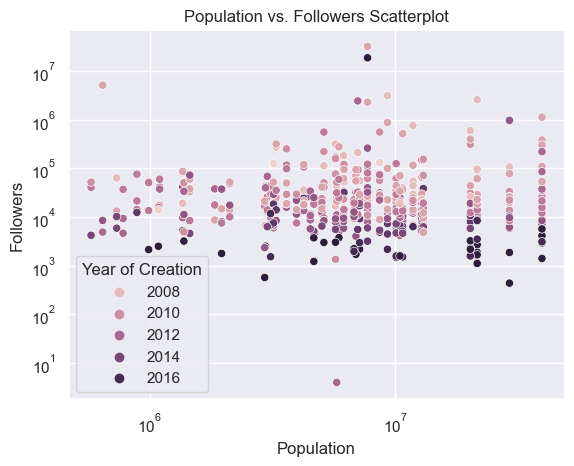

In [363]:
import seaborn as sns
sns.set_theme()
sns.set_style("darkgrid")

sns.scatterplot(x='State Population', y='Followers',hue='Year of Creation', data=fvS_df)
plt.xlabel("Population")
plt.ylabel("Followers")
plt.title("Population vs. Followers Scatterplot")
plt.xscale('log')
plt.yscale('log')

# Show the plot
plt.show()

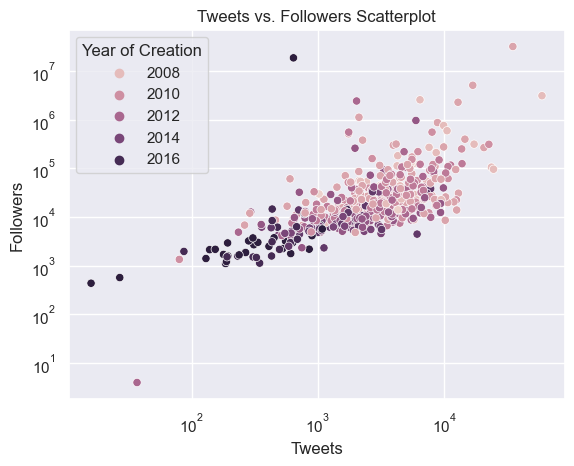

In [366]:
sns.scatterplot(x='Number of Tweets', y='Followers',hue='Year of Creation', data=fvS_df)

# Set labels and a title
plt.xlabel("Tweets")
plt.ylabel("Followers")
plt.title("Tweets vs. Followers Scatterplot")
plt.xscale('log')
plt.yscale('log')

# Show the plot
plt.show()

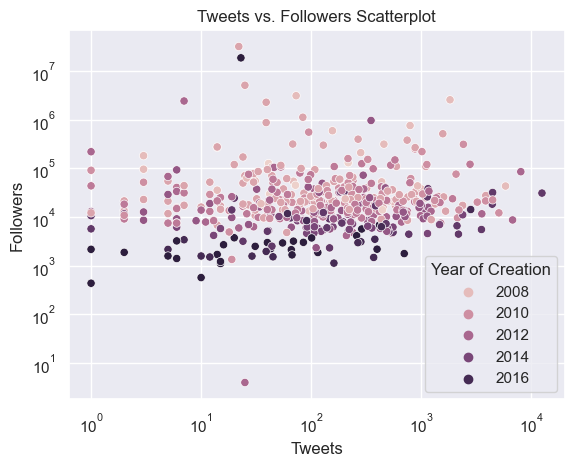

In [367]:
sns.scatterplot(x='Times Favorited', y='Followers',hue='Year of Creation', data=fvS_df)

# Set labels and a title
plt.xlabel("Tweets")
plt.ylabel("Followers")
plt.title("Tweets vs. Followers Scatterplot")
plt.xscale('log')
plt.yscale('log')

# Show the plot
plt.show()

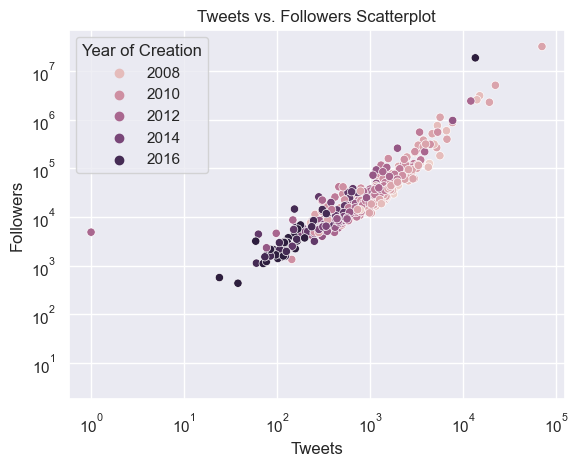

In [368]:
sns.scatterplot(x='Times Listed', y='Followers',hue='Year of Creation', data=fvS_df)

# Set labels and a title
plt.xlabel("Tweets")
plt.ylabel("Followers")
plt.title("Tweets vs. Followers Scatterplot")
plt.xscale('log')
plt.yscale('log')

# Show the plot
plt.show()

In [377]:
res = cur.execute ("SELECT u.name AS Name, \
                           a.followers_count AS Followers, \
                           SUM(t.favorite_count + t. retweet_count) AS virality \
                    FROM tweets t \
                    JOIN users u \
                    ON t.user_id = u.id \
                    JOIN accounts a \
                    ON a.user_id = t.user_id \
                    GROUP BY u.name \
                    ORDER BY virality DESC")
vir_df = pd.DataFrame(res.fetchall())
vir_df.columns = ['Name','Followers','Virality (Retweets+Likes)']
vir_df.head()

,Name,Followers,Virality (Retweets+Likes)
0,Donald J. Trump,31712585,178628324
1,Bernie Sanders,5072538,46371460
2,President Trump,18545354,15415791
3,Elizabeth Warren,2412087,11862249
4,Adam Schiff,298997,7576164


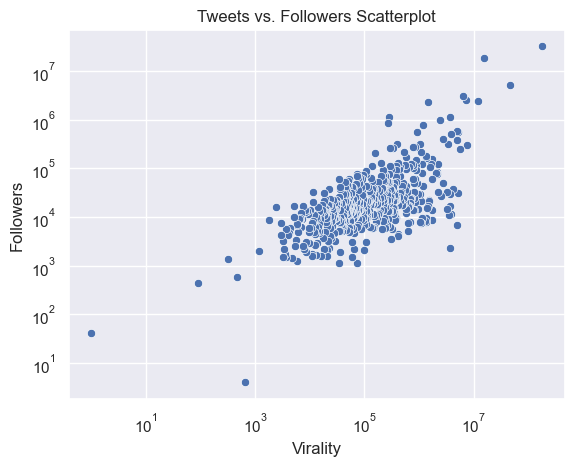

In [380]:
sns.scatterplot(x='Virality (Retweets+Likes)', y='Followers', data=vir_df)

# Set labels and a title
plt.xlabel("Virality")
plt.ylabel("Followers")
plt.title("Tweets vs. Followers Scatterplot")
plt.xscale('log')
plt.yscale('log')

# Show the plot
plt.show()

In [381]:
con.close()